In [7]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.pyplot import subplots
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
np.random.seed(42)
data = pd.read_pickle('/home/jinzhuo/ww_dataset/SCCML/data/SIMS.pkl')
types = list({t for t in data['type']})
types = sorted(types)

import joblib
model = joblib.load('/home/jinzhuo/ww_dataset/DECOMPOSITION/model_save_file/xgboost_model_SIMS.pkl')
import shap
from shap import TreeExplainer
shap_explainer = TreeExplainer(model)
shap_values = shap_explainer.shap_values(data.drop(['type'],axis =1))
shap_values = shap_values.reshape(1,1542,4667)
features = data.columns[1:]
shap_index = []
shap_num = 9
for i in range(1):
    contrib_xgb_best = shap_values[i]
    shap_ranked_index = np.argsort(abs(contrib_xgb_best).mean(0))[::-1]
    shap_index.append(shap_ranked_index)
shap_index = np.array(shap_index)
shap_index = shap_index[:,:shap_num]
shap_index = shap_index.reshape(-1)
shap_index = list(set(list(shap_index)))
print(len(shap_index))
print(shap_index)

data_matrix_list_train = []
mean = []
num_for_mean = 100
for i in range(len(types)):
    array_temp = np.array(data[data['type']==types[i]].drop(['type'],axis  = 1))[:,shap_index]
    print(array_temp.shape,types[i])
    # 计算每一行的和
    row_sums = np.sum(array_temp, axis=1)
    # 获取按照行和排序的索引
    sorted_indices = np.argsort(row_sums)
    # 根据排序索引对原始数组进行排序
    array_temp = array_temp[sorted_indices]
    array_temp = array_temp[:500]
    np.random.shuffle(array_temp)
    np.random.shuffle(array_temp)
    data_matrix_list_train.append(array_temp[num_for_mean:500])
    mean.append(np.mean(array_temp[:num_for_mean], axis = 0))
    print(data_matrix_list_train[i].shape,types[i])
cell_type_ref  = np.array(mean)

def MixDataset(data_matrix_list,noise_percentage,ratio):
    cell_type_num = len(data_matrix_list)
    data_matrix_list_noise = [None]*cell_type_num 
    for i in range(cell_type_num):
        noise = np.random.uniform(-0.1, 0.1, data_matrix_list[i].shape)
        data_matrix_list_noise[i] = data_matrix_list[i] + noise_percentage*noise*data_matrix_list[i]
    mix_sample_spec = np.empty((cell_type_num,data_matrix_list_noise[0].shape[-1]))
    for i in range(cell_type_num):
        if ratio[i] == 0:
            mix_sample_spec[i] = np.zeros(data_matrix_list_noise[0].shape[-1])
        else:
            random_indices = np.random.choice(data_matrix_list_noise[i].shape[0], ratio[i], replace=False)
            random_samples = data_matrix_list_noise[i][random_indices]
            mix_sample_spec[i] = np.sum(random_samples, axis=0)
    mix_sample_spec = np.sum(mix_sample_spec, axis=0)
    mix_sample_spec = mix_sample_spec + np.random.uniform(-0.1, 0.1, mix_sample_spec.shape)*noise_percentage*mix_sample_spec
    return mix_sample_spec
cell_type_ref

9
[3141, 3847, 3848, 3820, 3501, 3473, 3127, 3128, 3447]
(994, 9) CER
(400, 9) CER
(548, 9) DRG
(400, 9) DRG


array([[0.16987751, 0.13748949, 0.18640819, 0.02605426, 0.3027088 ,
        0.2599825 , 1.4964706 , 0.17510362, 0.06507553],
       [0.04782301, 0.3535386 , 0.06346973, 0.11884659, 0.09655063,
        0.7042698 , 0.7253415 , 0.06041963, 0.15839827]])

In [8]:
def norm_method(method,pretensor):
    if method == 'Min_Max_Scaling':
        min_vals, _ = torch.min(pretensor, dim=1, keepdim=True)
        max_vals, _ = torch.max(pretensor, dim=1, keepdim=True)
        posttensor = (pretensor - min_vals) / (max_vals - min_vals)
        # return posttensor
    elif method == 'z_score':
        mean = pretensor.mean()
        std = pretensor.std()
        # 对Tensor进行Z-Score归一化
        posttensor = (pretensor - mean) / std
    
    elif method == 'l2_norm':
        l2_norm = torch.norm(pretensor, p=2,dim = 1)
        # 进行L2范数归一化
        posttensor = pretensor / l2_norm[:,None]
    
    elif method == 'Max_Scaling':
        # min_vals, _ = torch.min(pretensor, dim=1, keepdim=True)
        max_vals, _ = torch.max(pretensor, dim=1, keepdim=True)
        posttensor = (pretensor) / (max_vals)
    return posttensor

class MyModel(nn.Module):
    def __init__(self,cell_type_num,init_choice):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.rand(1, cell_type_num))  # 定义一个10x10的可学习矩阵
        if init_choice == True:
            init.constant_(self.weight, 1/cell_type_num)
    def forward(self, x,norm_method_name):
        output = torch.mm(self.weight/torch.sum(self.weight),x)  # 使用可学习的矩阵进行矩阵乘法运算
        output = norm_method(norm_method_name,output)
        return output    

# 定义一个函数来裁剪权重
def clip_weights(model, min_clip=0.0, max_clip=1.0):
    for param in model.parameters():
        if param.requires_grad:
            param.data = torch.clamp(param.data, min_clip, max_clip)


def linear_deconvolution(cell_type_num,target,cell_ref,init_choice,clip_choice,lossfunc_name,norm_method_name):
    model = []
    model = MyModel(cell_type_num,init_choice)
    if lossfunc_name == 'mae':
        lossfunc = nn.L1Loss()
    elif lossfunc_name == 'mse':
        lossfunc = nn.MSELoss()
    elif lossfunc_name == 'smooth':
        lossfunc = nn.SmoothL1Loss()
    # model.to(device)
    LEARNING_RATE = 0.001
    optimizer = []
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_step = 1000
    # cell_ref = cell_ref.to(device)
    # target = target.to(device)
    for i in range(train_step):
        output = model(cell_ref,norm_method_name)
        # loss = lossmse(output,target)
        loss = lossfunc(output,target)
        # loss = losssmooth(output,target)
        # print("loss",loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if clip_choice == True:
            clip_weights(model, min_clip=0, max_clip=1.0)
    return model.weight/torch.sum(model.weight)


# import random
def ratio_num_generate(totalcellnum,celltypechoice,totalcelltype):
    ratio = [0]*totalcelltype
    norm_ratio = [0]*len(celltypechoice)
    random_integers = []
    # 生成三个随机整数
    for _ in range(len(celltypechoice)-1):
        random_integer = np.random.randint(1, totalcellnum - sum(random_integers) - 2)
        random_integers.append(random_integer)

    # 计算第四个整数以确保和为N
    last_integer = totalcellnum - sum(random_integers)
    random_integers.append(last_integer)

    np.random.shuffle(random_integers)

    for i in range(len(random_integers)):
        ratio[celltypechoice[i]] = random_integers[i]
        norm_ratio[i] = random_integers[i]/sum(random_integers)

    
    return ratio,norm_ratio

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# def split_data(data,test_size,random_state):

#     X_train, X_test, y_train, y_test = train_test_split(data.drop('type',axis = 1).values, data['type'].values, 
#                                                         test_size=test_size,
#                                                         random_state=random_state)
#     print(y_train)
#     y_train = le.fit_transform(y_train)
#     print(y_train)
#     y_test = le.fit_transform(y_test)

#     data_dict = {'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test}

#     return data_dict

# data_dict_icc = split_data(data = data,test_size=0.2,random_state=11)

# import xgboost
# from sklearn.metrics import classification_report 
# model = xgboost.XGBClassifier(n_estimators=600,subsample=0.8)
# def train_model(model,data_dict):
    
#     model.fit(data_dict['X_train'],data_dict['y_train'])

#     y_pred = model.predict(data_dict['X_test'])
#     prob = model.predict_proba(data_dict['X_test'])
#     report_dict = classification_report(data_dict['y_test'], y_pred, output_dict=True)
    
#     return model, y_pred, prob,report_dict

# model,y_pred,prob,report_dict = train_model(model,data_dict_icc)

In [9]:


def train(init_choice ,clip_choice ,lossfunc_name,sample_list,celltypechoice,norm_method_name):
    for j in range(200):
        ratio,norm_ratio = ratio_num_generate(50*2,celltypechoice,2)
        # MixSample = MixDataset(data_matrix_list_train,ratio)
        MixSample = MixDataset(data_matrix_list_train,3,ratio)
        target = MixSample.reshape(1,-1)
        target = torch.from_numpy(target).float()
        target = norm_method(norm_method_name,target)
        predict = linear_deconvolution(2,target,torch.from_numpy(cell_type_ref[celltypechoice,:]).float(),init_choice = init_choice,clip_choice=clip_choice,lossfunc_name = lossfunc_name,norm_method_name = norm_method_name )
        
        print(lossfunc_name,j,predict,norm_ratio,ratio)
        sample_list.append([predict,norm_ratio,ratio])
    return sample_list
celltypechoice = [0,1]

# sample_listmae = []
# sample_listmse = []
# sample_listsmooth = []
# sample_list_withoutinit = []
# sample_list_withoutclip = []
# sample_list_withoutinitandclip = []
# sample_listmae = train(init_choice = True ,clip_choice=True ,lossfunc_name='mae',sample_list=sample_listmae,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')
# sample_listmse = train(init_choice = True ,clip_choice=True ,lossfunc_name='mse',sample_list=sample_listmse,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')
# sample_listsmooth = train(init_choice = True ,clip_choice=True ,lossfunc_name='smooth',sample_list=sample_listsmooth,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')
# sample_list_withoutclip = train(init_choice = True ,clip_choice=False ,lossfunc_name='mse',sample_list=sample_list_withoutclip,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')
# sample_list_withoutinit = train(init_choice = False ,clip_choice=True ,lossfunc_name='mse',sample_list=sample_list_withoutinit,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')
# sample_list_withoutinitandclip = train(init_choice = False ,clip_choice=False ,lossfunc_name='mse',sample_list=sample_list_withoutinitandclip,celltypechoice = celltypechoice,norm_method_name = 'Min_Max_Scaling')

In [10]:
sample_listmse = []
sample_listmse = train(init_choice = True ,clip_choice=True ,lossfunc_name='mse',sample_list=sample_listmse,celltypechoice = celltypechoice,norm_method_name = 'z_score')
with open('/home/jinzhuo/ww_dataset/DECOMPOSITION/dataset2output/'+'z_score'+'-'+'mse'+str(shap_num)+'.pkl', 'wb') as file:
    pickle.dump(sample_listmse, file)

mse 0 tensor([[0.4346, 0.5654]], grad_fn=<DivBackward0>) [0.28, 0.72] [28, 72]
mse 1 tensor([[0.5855, 0.4145]], grad_fn=<DivBackward0>) [0.6, 0.4] [60, 40]
mse 2 tensor([[0.9116, 0.0884]], grad_fn=<DivBackward0>) [0.81, 0.19] [81, 19]
mse 3 tensor([[0.3670, 0.6330]], grad_fn=<DivBackward0>) [0.3, 0.7] [30, 70]
mse 4 tensor([[0.5381, 0.4619]], grad_fn=<DivBackward0>) [0.62, 0.38] [62, 38]
mse 5 tensor([[0.6822, 0.3178]], grad_fn=<DivBackward0>) [0.75, 0.25] [75, 25]
mse 6 tensor([[0.1992, 0.8008]], grad_fn=<DivBackward0>) [0.16, 0.84] [16, 84]
mse 7 tensor([[0.2122, 0.7878]], grad_fn=<DivBackward0>) [0.12, 0.88] [12, 88]
mse 8 tensor([[0.4748, 0.5252]], grad_fn=<DivBackward0>) [0.43, 0.57] [43, 57]
mse 9 tensor([[0.4927, 0.5073]], grad_fn=<DivBackward0>) [0.38, 0.62] [38, 62]
mse 10 tensor([[0.3850, 0.6150]], grad_fn=<DivBackward0>) [0.37, 0.63] [37, 63]
mse 11 tensor([[1., 0.]], grad_fn=<DivBackward0>) [0.96, 0.04] [96, 4]
mse 12 tensor([[0.9375, 0.0625]], grad_fn=<DivBackward0>) [0.93

In [ ]:
name_norm = ['Min_Max_Scaling','z_score','l2_norm']
for name in name_norm:
    sample_listmae = []
    sample_listmse = []
    sample_listsmooth = []
    sample_listmae = train(init_choice = True ,clip_choice=True ,lossfunc_name='mae',sample_list=sample_listmae,celltypechoice = celltypechoice,norm_method_name = name)
    sample_listmse = train(init_choice = True ,clip_choice=True ,lossfunc_name='mse',sample_list=sample_listmse,celltypechoice = celltypechoice,norm_method_name = name)
    sample_listsmooth = train(init_choice = True ,clip_choice=True ,lossfunc_name='smooth',sample_list=sample_listsmooth,celltypechoice = celltypechoice,norm_method_name = name)
    ppp = [sample_listmae,sample_listmse,sample_listsmooth]
    ppp_name = ['mae','mse','smooth']
    for m,n in zip(ppp,ppp_name):
        with open('/home/jinzhuo/ww_dataset/DECOMPOSITION/dataset2output/'+name+'-'+n+str(shap_num)+'.pkl', 'wb') as file:
            pickle.dump(m, file)

In [ ]:
prin

In [12]:
def caculate_metrics(list1,list2):
    x = np.array(list1)
    y = np.array(list2)
    # 计算均值
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    rmse = np.sqrt(np.mean((x - y) ** 2))
    # 计算标准差
    std_x = np.std(x)
    std_y = np.std(y)

    # 计算皮尔逊相关系数
    pearson_corr = np.corrcoef(x, y)[0, 1]

    # 计算 Lin's CCC
    ccc = (2 * pearson_corr * std_x * std_y) / (std_x**2 + std_y**2 + (mean_x - mean_y)**2)

    coefficients = np.polyfit(x, y, 1)
    m = coefficients[0]
    b = coefficients[1]

    predicted_y = [m * xx+b for xx in x]
    # 计算残差
    residuals = [a - b for a, b in zip(y,predicted_y)]
    # 计算残差的标准差
    residual_std = np.std(residuals)

    return pearson_corr,ccc,residual_std,m,b,coefficients,rmse
def withoutnan(output,target):
    i = 0
    output_without_nan = []
    target_without_nan = []
    for x in output:
        # if not np.isnan(x) and x>=0 and x<=1:
        if not np.isnan(x):
            output_without_nan.append(output[i])
            target_without_nan.append(target[i])
        i = i+1
    return output_without_nan,target_without_nan

def ListDimConvert(two_dim_list):
    one_dim_list = [item for sublist in two_dim_list for item in sublist]
    return one_dim_list

def plot_point_line(target_list,output_list,savename,loc,save_choice):
    plt.figure(figsize=(9,6))
    # Example points
    x_stick = target_list
    y_stick = output_list

    # Create a scatter plot for the points
    plt.scatter(x_stick, y_stick, c="purple", cmap='viridis',alpha=0.7)
    pearson_corr,ccc,residual_std,m,b,coefficients,rmse = caculate_metrics(x_stick,y_stick)



    #equation_text
    all_text = f'y = {m:.3f}x + ({b:.3f})\nres_std = {residual_std:.4f}\nPearson\'s r = {pearson_corr:.4f}\nLin\'s ccc = {ccc:.4f}\nRMSE = {rmse:.4f}'
    equation_text = f'y = {m:.3f}x + ({b:.3f})'
    plt.text(0,1,equation_text,fontsize = 20,color = 'black')

    # res_std = f'res_std = {residual_std:.3f}'
    # corr_coeff = f'Pearson\'s r = {pearson_corr:.3f}'    
    # lin_ccc = f'Lin\'s ccc = {ccc:.3f}'  

   # Create the line equation
    line = np.poly1d(coefficients)
    x_line = np.linspace(min(x_stick), max(x_stick), 100)
    y_line = line(x_line)
    

    # Plot the regression line
    # plt.plot(x_line, y_line, linestyle = '--',label=f'Fitted Line (Slope = {m:.2f},residual_std = {residual_std:.2f})', color='y')
    plt.plot(x_line, y_line, linestyle = '--', color='y')
    
    
    # plt.text(1.05,0,all_text,fontsize = 15,color = 'black')
    # plt.axhline(y=1, color='r', linestyle=':')
    # # 绘制y=0的虚线
    # plt.axhline(y=0, color='r', linestyle=':')
    
    # plt.text(0.5,0.13,res_std,fontsize = 15,color = 'b')
    # plt.text(0.5,0.06,corr_coeff,fontsize = 15,color = 'b')
    # plt.text(0.5,-0.01,lin_ccc,fontsize = 15,color = 'b')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    # plt.axis('equal')


    
    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.xticks(fontsize=15)
    # Add labels and legend
    plt.xlabel('True Fraction',size = 20)
    plt.yticks(fontsize=15)
    plt.ylabel('Predicted Fraction',size = 20)
    plt.legend(loc=loc)

    # Show the plot
    # plt.grid(True)
    if save_choice == True:    
        plt.savefig(savename,format = 'svg',dpi = 300)
    plt.show()
    print(all_text)

def process_plot(sample_list,savename,save_choice):
    output1 = []
    output2 = []
    # output3 = []
    target1 = []
    target2 = []
    # target3 = []
    for j in  range(len(sample_list)):
        predict,target_ratio,ratio_num = sample_list[j]
        predict1 = predict[:,0].tolist()
        predict2 = predict[:,1].tolist()
        # predict3 = predict[:,2].tolist()

        output1.append(predict1)
        output2.append(predict2)
        # output3.append(predict3)

        target_ratio1 = target_ratio[0]
        target_ratio2 = target_ratio[1]
        # target_ratio3 = target_ratio[2]

        target1.append(target_ratio1)
        target2.append(target_ratio2)
        # target3.append(target_ratio3)

    output1 = ListDimConvert(output1)
    output2 = ListDimConvert(output2)
    # output3 = ListDimConvert(output3)

    output1,target1 = withoutnan(output1,target1)
    output2,target2 = withoutnan(output2,target2)
    # output3,target3 = withoutnan(output3,target3)
    plot_point_line(target1,output1,'/home/jinzhuo/ww_dataset/DECOMPOSITION/dataset2output/'+'01'+savename,'upper left',save_choice)
    # plot_point_line(target2,output2,'/home/jinzhuo/ww_dataset/DECOMPOSITION/temp-norm/photosvg/'+'02'+savename,'upper left',save_choice)
    # plot_point_line(target3,output3,lossfunc+'-'+'135-5.svg','upper left',save_choice)
# process_plot(sample_listmse_maxscale,'mse_maxscale',save_choice = False)
# process_plot(sample_listmae,'mae',save_choice = False)
# process_plot(sample_listmse,'mse',save_choice = False)
# process_plot(sample_listsmooth,'smooth',save_choice = False)
# process_plot(sample_list_withoutinitandclip,'withoutinitandclip',save_choice = False)
# process_plot(sample_list_withoutinit,'withoutinit',save_choice = False)
# process_plot(sample_list_withoutclip,'withoutclip',save_choice = False)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


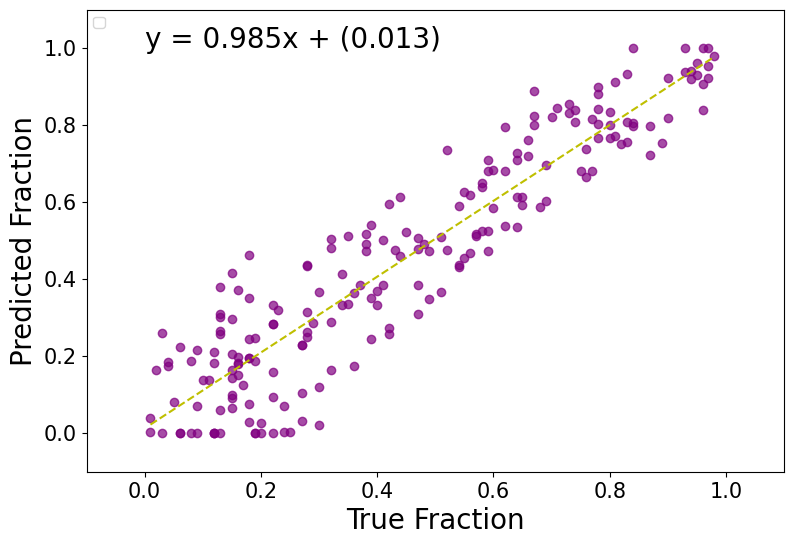

y = 0.985x + (0.013)
res_std = 0.1104
Pearson's r = 0.9280
Lin's ccc = 0.9262
RMSE = 0.1106


In [13]:
with open('/home/jinzhuo/ww_dataset/DECOMPOSITION/dataset2output/z_score-mse9.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
process_plot(loaded_data,'z_score-mse9.svg',save_choice = False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建数据
#LinCCC
# data = np.array([[0.8716, 0.8628, 0.8180],
#                  [0.9290, 0.9311, 0.9186],
#                  [0.9357, 0.9124, 0.9110]])
#STD
# data = np.array([[0.1297, 0.1393, 0.1435],
#                  [0.1108, 0.1069, 0.1146],
#                  [0.0964 , 0.1186, 0.1194]])
# P R
data = np.array([[0.8814, 0.8706, 0.8247],
                 [0.9296, 0.9317, 0.9214],
                 [0.9371 , 0.9131, 0.9121]])

# 创建热图
fig, ax = plt.subplots()
cax = ax.matshow(data, cmap='YlGnBu')  # 使用YlGnBu颜色映射，你可以选择其他颜色映射

# 添加颜色条
cbar = plt.colorbar(cax)

# 添加横轴和纵轴标签
plt.xticks(range(data.shape[1]), ['MAE', 'MSE', 'SMOOTH'])
plt.yticks(range(data.shape[0]), ['Min-Max', 'L2-Norm', 'Z-Score'])

# 显示数值文本在每个方格中
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, data[i, j], ha='center', va='center', color='black')
plt.savefig('/home/jinzhuo/ww_dataset/DECOMPOSITION/temp-norm-new/photosvg/pearson.svg',format = 'svg',dpi = 300)
# 显示热图
plt.show()
